In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
# import tqdm
import torch

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
import src.mace.neuralODE    as nODE
import src.mace.plotting     as pl

In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden
epochs = 1
lr = 1e-2

kwargs = {'num_workers': 1, 'pin_memory': True} 

dirname = 'C-short-dtime'
# writer = SummaryWriter('runs/'+dirname)

train, data_loader, test_loader = ds.get_data(dirname = dirname, batch_size=batch_size, kwargs=kwargs, plot = True, scale = None)
model = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466, DEVICE = DEVICE)

Dataset:
------------------------------
total # of samples: 13562
# training samples: 9493
# testing samples:  4069
            ratio:  0.3


In [3]:
## Training & validating model

loss_train_all, loss_test_all = tr.train(model, lr, data_loader, test_loader, epochs, DEVICE)
n_test, n_test_hat, tstep, loss = tr.test(model, test_loader, DEVICE)

Model:         
learning rate: 0.01

>>> Training model...
Epoch 1 complete! 	Average loss train:  0.00034551752489005773 	Average loss test:  7.341122545767576e-05
 	DONE!

>>> Testing model...
	batch 1 / 4069 , # nan 0
Test loss: 7.341122545767576e-05


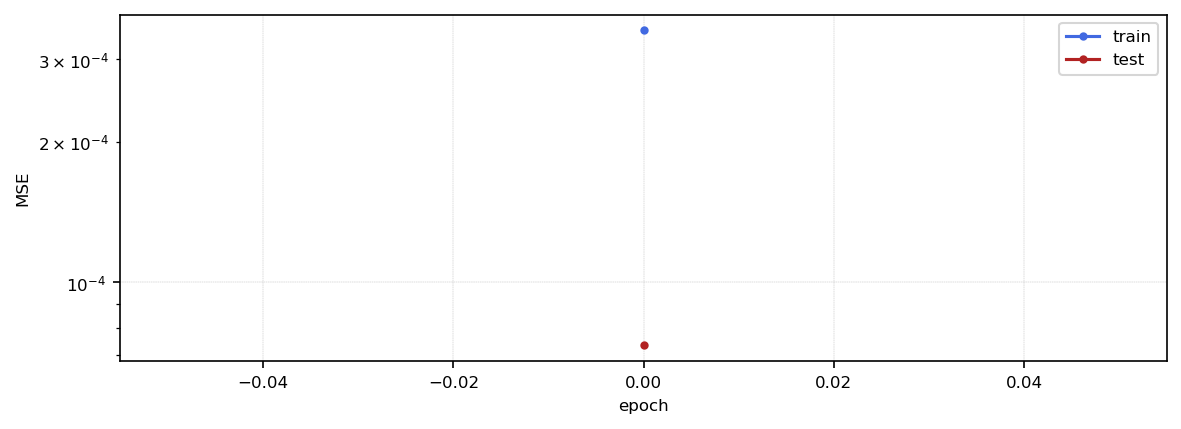

In [4]:
pl.plot_loss(loss_train_all, loss_test_all, log = True)


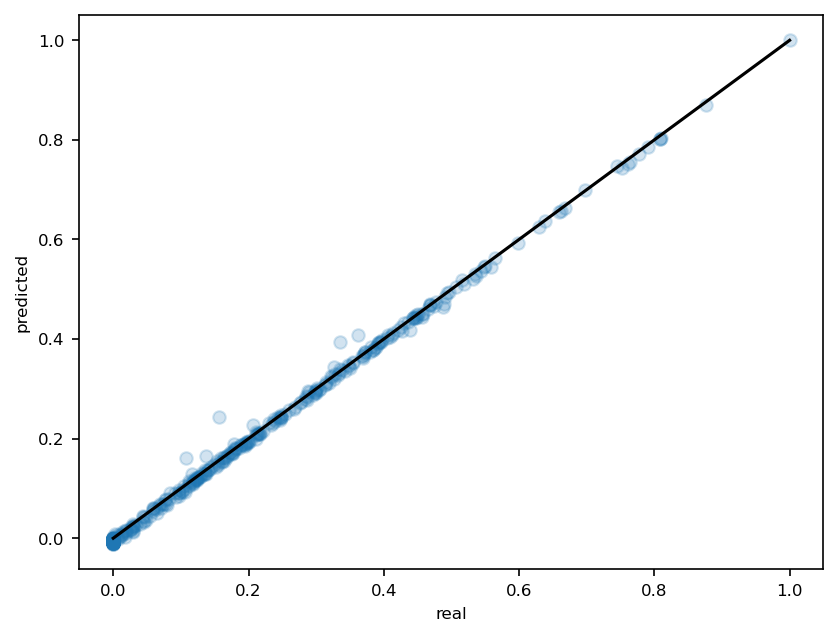

In [5]:
i = 0
x = np.linspace(0,1,100)

# for i in range(n_test.shape[1]):

    # print(n_test_hat[0][i])
    # print(n_test[0][i])
plt.plot(n_test[0][i],n_test_hat[0][i], 'o', alpha = 0.2)
plt.plot(x,x,c='k')

plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

tensor([[-2.4605e-06],
        [-2.2198e-06],
        [-1.9790e-06],
        [ 4.2852e-07],
        [ 2.8360e-06],
        [ 2.6911e-05],
        [ 5.0987e-05],
        [ 2.8444e-04],
        [ 5.1790e-04],
        [ 7.5135e-04],
        [ 1.5013e-03],
        [ 2.0786e-03],
        [ 2.6558e-03],
        [ 3.0692e-03]])


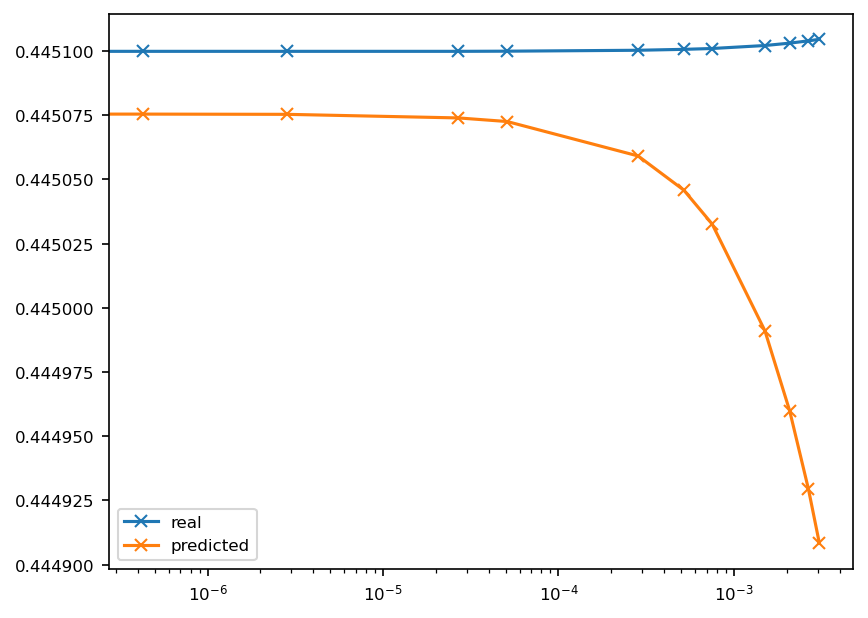

In [12]:
n_i = n_test.view(n_test.shape[1], -1)
n_i.shape

n_hat = n_test_hat.view(n_test_hat.shape[1], -1)
t = tstep.view(tstep.shape[1], -1)

print(t)

mol = 150
plt.plot(t, n_i[:,mol],  '-x',label = 'real')
plt.plot(t,n_hat[:,mol], '-x',label = 'predicted')
# mol = 72
# plt.plot(n_i[:,mol])

plt.xscale('log')
plt.legend()
plt.show()

### Testing seperately

In [4]:
enc = ae.Encoder( 470, 100, 10)
dec = ae.Decoder(10,100,466)

i = 849
n_test = train[i][0]
n_0    = n_test[:,0]
p      = train[i][1]
t      = train[i][2]

In [11]:
for p in enc.parameters():
    p.requires_grad_(False)
    print(p.requires_grad)


False
False
False
False


In [5]:
t

tensor([-2.4605e-06, -2.1805e-06, -1.9006e-06,  8.9903e-07,  3.6986e-06,
         3.1695e-05,  5.9691e-05,  3.1945e-04,  5.7921e-04,  8.3896e-04,
         1.5936e-03,  2.3481e-03,  2.7568e-03])

In [14]:
z_0= enc(torch.cat((p, n_0), axis=0))

z_0

tensor([ 0.0922,  0.0054, -0.0003,  0.0963,  0.0684, -0.0162,  0.0080, -0.0013,
        -0.0047, -0.0070], grad_fn=<LeakyReluBackward0>)

In [5]:
torch.cat((p, n_0), axis=0).shape

torch.Size([470])

In [15]:
g = nODE.G(4,10)
# z = z_0.view(1,10)
# g_fun = nODE.G.forward(g,t,z,p)
# print(g_fun)

In [ ]:
A = nODE.A(466, 10)
print(A.layer_out.bias.data)

tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.])


In [ ]:
A = model.g.a(p)
# torch.linalg.eig(A)
print(A)

tensor([[-0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.2000,  0.0000],
        [ 0.0000,  

In [ ]:
n_s = model(n_0, p, t.view(1,-1))
n_s

status        tensor([0])


tensor([[[-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         ...,
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120]]],
       grad_fn=<ReshapeAliasBackward0>)